In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Load Data
df = pd.read_excel("Fraud.csv.xlsx")

print("Shape:", df.shape)
print(df.head())

Shape: (1048575, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [35]:
# 2️⃣ Inject synthetic fraud samples (for testing only)
print("Original class distribution:\n", df["isFraud"].value_counts())

n_fake_fraud = 200
fake_fraud_rows = df[df["isFraud"] == 0].sample(n=n_fake_fraud, random_state=42).copy()
fake_fraud_rows["isFraud"] = 1
# Optionally tweak numeric features
for col in fake_fraud_rows.select_dtypes(include=[np.number]).columns:
    if col != "isFraud":
        fake_fraud_rows[col] = fake_fraud_rows[col] * np.random.uniform(1.2, 1.5)
df = pd.concat([df, fake_fraud_rows], ignore_index=True)

print("\nAfter synthetic fraud injection:\n", df["isFraud"].value_counts())

Original class distribution:
 isFraud
0    538225
1       200
Name: count, dtype: int64

After synthetic fraud injection:
 isFraud
0    538225
1       400
Name: count, dtype: int64


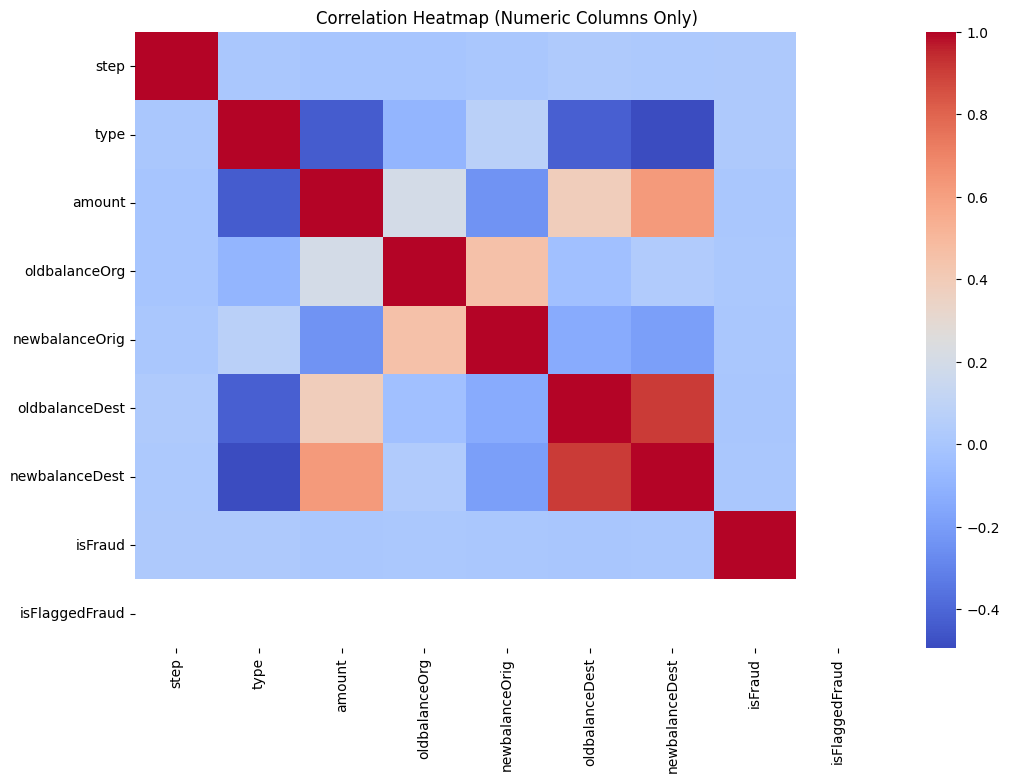

In [36]:
# 3️⃣ Correlation Heatmap (numeric features only)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

In [37]:
# 4️⃣ Split features and target
target = "isFraud"
X = df.drop(columns=[target])
y = df[target]

In [49]:
# 2️⃣ Check class distribution
print("\nFull dataset class distribution:")
print(df['isFraud'].value_counts())


Full dataset class distribution:
isFraud
0    538225
1       400
Name: count, dtype: int64


In [50]:
# 2️⃣ Check class distribution
print("\nFull dataset class distribution:")
print(df['isFraud'].value_counts())


Full dataset class distribution:
isFraud
0    538225
1       400
Name: count, dtype: int64


In [51]:
# 3️⃣ Drop non-informative ID columns
df = df.drop(columns=['nameOrig', 'nameDest'])

In [52]:
target = "isFraud"

# Correct:
X = df.drop(columns=[target])
y = df[target]

print(X.head())
print(y.value_counts())


   step  type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   1.0   3.0   1864.28        21249.0        19384.72             0.0   
1   1.0   3.0  11668.14        41554.0        29885.86             0.0   
2   1.0   3.0   7817.71        53860.0        46042.29             0.0   
3   1.0   3.0   4024.36         2671.0            0.00             0.0   
4   1.0   2.0   5337.77        41720.0        36382.23         41898.0   

   newbalanceDest  isFlaggedFraud  
0            0.00             0.0  
1            0.00             0.0  
2            0.00             0.0  
3            0.00             0.0  
4        40348.79             0.0  
isFraud
0    538225
1       400
Name: count, dtype: int64


In [54]:

# 5️⃣ Check for categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns:", categorical_cols)
# Encode categorical columns if any exist
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


Categorical columns: []


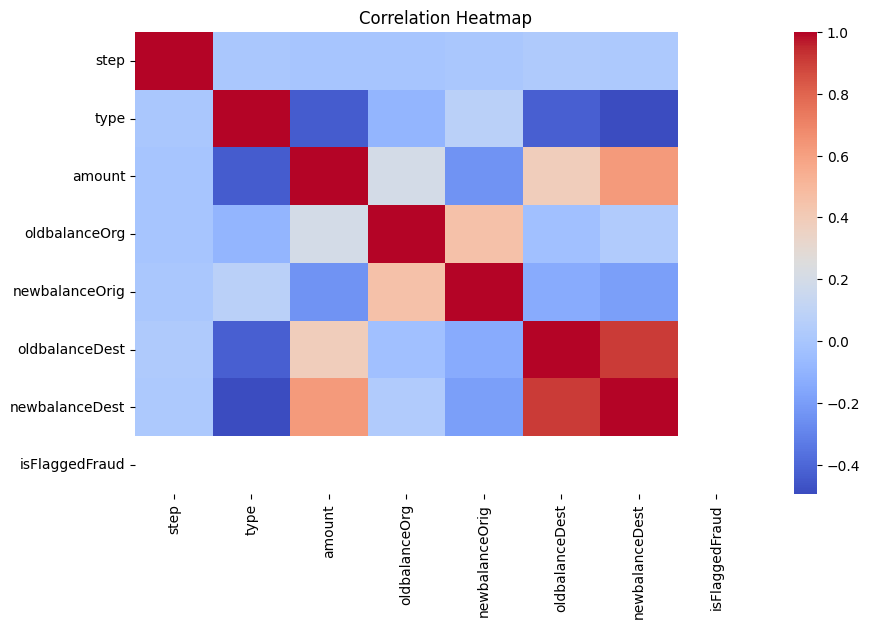

In [55]:
# 6️⃣ Correlation heatmap (numeric features only)
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [56]:

# 7️⃣ Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [57]:
from imblearn.over_sampling import SMOTE

# 8️⃣ Apply SMOTE to balance training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nBefore SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_res.value_counts())


Before SMOTE:
 isFraud
0    430580
1       320
Name: count, dtype: int64

After SMOTE:
 isFraud
0    430580
1    430580
Name: count, dtype: int64


In [58]:

# 9️⃣ Scale numeric features
numeric_cols = X_train_res.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [60]:

# 10️⃣ Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86    107645
           1       0.00      0.68      0.00        80

    accuracy                           0.76    107725
   macro avg       0.50      0.72      0.43    107725
weighted avg       1.00      0.76      0.86    107725

ROC-AUC Score: 0.7988553811138464


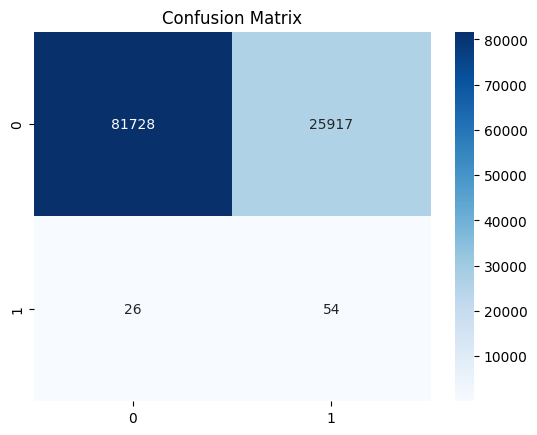

In [62]:

# 11️⃣ Evaluate Model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [63]:
# 12️⃣ Key Predictors
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)
print("\nKey Fraud Predictors:\n", coefficients)


Key Fraud Predictors:
           Feature  Coefficient
1            type     1.300568
6  newbalanceDest     0.883034
0            step     0.792120
2          amount     0.560336
4  newbalanceOrig     0.334551
3   oldbalanceOrg     0.061171
7  isFlaggedFraud     0.000000
5  oldbalanceDest    -0.488827


In [64]:
# 13️⃣ Prevention Strategies (conceptual)
print("""
Prevention:
- Strengthen identity verification
- Real-time transaction monitoring
- Update anomaly detection rules
- Limit risky transactions

Monitoring Effectiveness:
- Compare fraud rate before & after changes
- Track false positive & false negative trends
- Monitor ROC-AUC over time
""")


Prevention:
- Strengthen identity verification
- Real-time transaction monitoring
- Update anomaly detection rules
- Limit risky transactions

Monitoring Effectiveness:
- Compare fraud rate before & after changes
- Track false positive & false negative trends
- Monitor ROC-AUC over time



In [1]:
model.score(x_test,y_test)*100

NameError: name 'model' is not defined